## Computing the true $\textrm{div}(p_t(x)v_t(x))$ and $\partial_t p_t(x)$ terms with probability flow vector field

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def true_probability_path(target_sigma_squared, beta, x, t):
    distrib = torch.distributions.multivariate_normal.MultivariateNormal(
        loc=torch.zeros((1,2)), 
        covariance_matrix=(target_sigma_squared + (beta * t)) * torch.eye(2),
        validate_args=False
    )
        
    return distrib.log_prob(x).exp()

def hopefully_true_time_derivative(target_sigma_squared, beta, x, t):  
    first_term = beta / (2 * (target_sigma_squared + (beta * t)))
    second_term = (torch.linalg.norm(x, ord=2, dim=-1).pow(2) / (target_sigma_squared + (beta * t))) - x.shape[-1]
    third_term = true_probability_path(target_sigma_squared, beta, x, t)

    return first_term * second_term * third_term

def direct_time_derivative(target_sigma_squared, beta, x, t):
    prob_path_fxn = partial(true_probability_path, target_sigma_squared, beta)
    grad_fxn = torch.func.jacrev(prob_path_fxn, argnums=1)
    return torch.vmap(grad_fxn)(x, t)

def true_divergence(target_sigma_squared, beta, vector_field, x, t):
    def likelihood_vf_product(x_val, t_val):
        pdf_vals = true_probability_path(target_sigma_squared, beta, x_val, t_val)
        vf_vals = vector_field(x_val.to(device=DEVICE), t_val.to(device=DEVICE))
        
        return pdf_vals * vf_vals.to(device='cpu')
    
    jac_fxn = torch.func.jacfwd(likelihood_vf_product)
    jacs = torch.vmap(jac_fxn)(x, t)

    return torch.vmap(torch.trace)(jacs)

def true_gaussian_path_score(target_sigma_squared, beta, x, t):
    return -x / (target_sigma_squared + (beta * t))

In [2]:
# Define values to compute for

x = torch.tensor([[2.0, -2.0]])
t = torch.linspace(0.0, 1.0, 100)
x = x.expand(100, 2)

target_sigma_squared = 4
beta = 5

Text(0.5, 0, '$t$')

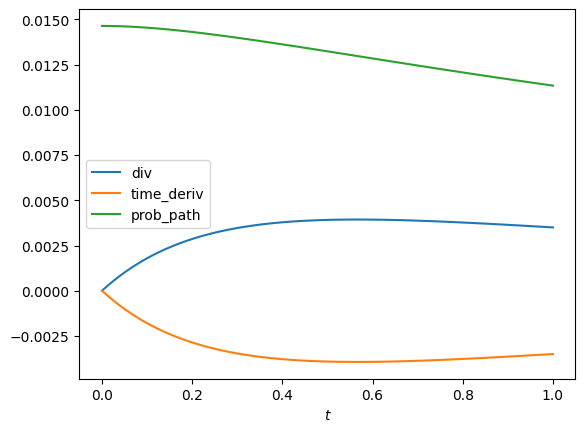

In [3]:
# Plot!

gaussian_score = partial(true_gaussian_path_score, target_sigma_squared, beta)
plt.plot(t, -beta / 2 * true_divergence(target_sigma_squared, beta, gaussian_score, x, t).detach(), label='div')

partial_fxn = partial(hopefully_true_time_derivative, target_sigma_squared, beta)
time_deriv = torch.vmap(partial_fxn)(x, t).squeeze()

partial_path = partial(true_probability_path, target_sigma_squared, beta)
plt.plot(t, time_deriv, label='time_deriv')
plt.plot(t, torch.vmap(partial_path)(x, t).detach(), label='prob_path')

plt.legend()

plt.xlabel(r'$t$')

## Reward fxn definition stuff

In [4]:
class GaussianRewardFunction:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance
        self.dimensionality = self.mean.shape[-1]
        
    def get_unnormalized_log_reward(self, x):
        return -0.5 * (torch.linalg.norm(x - self.mean, ord=2, dim=-1).pow(2) / self.variance)
    
    def get_unnormalized_reward(self, x):
        return self.get_unnormalized_log_reward(x).exp()
    
    @property
    def normalization_constant(self):
        return (2 * np.pi * self.variance) ** (self.dimensionality / 2)

## Approximations code
Approximations are $\partial_t p_t(x) = Z^{-1}E_{x'\sim \mathcal{N}(x, h(t))}\left[R(x')\frac{\partial_t h(t)}{2h(t)}\left(\frac{\|x' - x\|^2}{h(t)} - k\right)\right]$, $\textrm{div}(p_t(x) v_t(x)) = Z^{-1}E_{x'\sim \mathcal{N}(x,h(t))}\left[R(x')(\langle \nabla \log R(x'), v_t(x)\rangle + \textrm{div}(v_t(x)))\right]$

In [5]:
def uniform_sample_range(min_val, max_val, num_samples):
    return ((min_val - max_val) * torch.rand(num_samples)) + max_val

def true_time_derivative(target_sigma_squared, beta, x, t):  
    first_term = beta / (2 * (target_sigma_squared + (beta * t)))
    second_term = (torch.linalg.norm(x, ord=2, dim=-1).pow(2) / (target_sigma_squared + (beta * t))) - x.shape[-1]
    third_term = true_probability_path(target_sigma_squared, beta, x, t)

    return first_term * second_term * third_term

def _get_time_deriv_scaling(reward_fxn, vector_field, constant_noise_scale, samples, x, t):
    # Scaling is (h'(t)/2h(t)) * ((||samples - x||^2 / h(t)) - dim)
    # For now we're using h(t) = t * beta, so h'(t) / h(t) = 1 / t
    if t.ndim == 2:
        t = t[:, 0]
        
    return (1 / (2 * t)) * (
        (torch.linalg.norm(samples - x, ord=2, dim=-1).pow(2) / (constant_noise_scale * t)) - x.shape[-1]
    )
    
def _get_divergence_term(reward_fxn, vector_field, constant_noise_scale, samples, x, t, return_vf=False):
    grad_fxn = torch.func.grad(reward_fxn.get_unnormalized_log_reward)
    unnormalized_scores = torch.vmap(grad_fxn)(samples)
    
    vf_at_xt = vector_field(x, t)
    inner_prod = (unnormalized_scores * vf_at_xt).sum(dim=-1)
    
    grad_fxn = torch.func.jacrev(vector_field)
    vf_jacs = torch.vmap(grad_fxn)(x, t)
    vf_divergence = torch.vmap(torch.trace)(vf_jacs)
    
    div_term = inner_prod + vf_divergence
    div_term = div_term * (constant_noise_scale / 2)
    #print(constant_noise_scale)    
        
    return (div_term, vf_at_xt) if return_vf else div_term

def _get_reward_weighted_term(reward_fxn, vector_field, num_mc_samples, constant_noise_scale, term_fxn, x, t):
    orig_len = len(x)
    if num_mc_samples > 1:
        x = x.repeat_interleave(num_mc_samples, dim=0)
        
        orig_t = t.clone()
        t = t.repeat_interleave(num_mc_samples, dim=0)

    t = t.unsqueeze(1)
    noise = constant_noise_scale * t
    samples = torch.normal(x, noise ** 0.5)
    
    terms = term_fxn(reward_fxn, vector_field, constant_noise_scale, samples, x, t)
    rewards = reward_fxn.get_unnormalized_reward(samples)
    
    weighted_terms = rewards * terms
    if num_mc_samples > 1:
        weighted_terms = weighted_terms.reshape(
            int(orig_len),
            num_mc_samples
        )
        
    return weighted_terms #/ reward_fxn.normalization_constant

def get_mc_time_deriv_term(reward_fxn, vector_field, num_mc_samples, constant_noise_scale, x, t):
    return _get_reward_weighted_term(reward_fxn, vector_field, num_mc_samples, constant_noise_scale, _get_time_deriv_scaling, x, t)

def get_mc_div_term(reward_fxn, vector_field, num_mc_samples, constant_noise_scale, x, t):
    return _get_reward_weighted_term(reward_fxn, vector_field, num_mc_samples, constant_noise_scale, _get_divergence_term, x, t)

def get_loss_term(reward_fxn, vector_field, num_mc_samples, constant_noise_scale, x, t, weight_by_norm=False, detach_norm=True, true_dt_pt=False, true_div=False, reward_thresh=1e-10):
    orig_len = len(x)
    if num_mc_samples > 1:
        x = x.repeat_interleave(num_mc_samples, dim=0)
        
        orig_t = t.clone()
        t = t.repeat_interleave(num_mc_samples, dim=0)

    t = t.unsqueeze(1)
    noise = constant_noise_scale * t
    samples = torch.normal(x, noise ** 0.5)
    
    if true_dt_pt:
        time_deriv_term = reward_fxn.normalization_constant * direct_time_derivative(target_sigma_squared, constant_noise_scale, x, t.squeeze()).squeeze().detach()
    else:
        time_deriv_term = _get_time_deriv_scaling(reward_fxn, vector_field, constant_noise_scale, samples, x, t)
        
    div_term, vf_vals = _get_divergence_term(reward_fxn, vector_field, constant_noise_scale, samples, x, t, True)
    rewards = reward_fxn.get_unnormalized_reward(samples)
    
    #if (rewards == 0.).any():
    #    print('Had zero reward!!!!')
    if not true_dt_pt:
        time_deriv_term = rewards * time_deriv_term
    
    if not true_div:
        div_term = rewards * div_term
        
    terms = time_deriv_term + div_term
    if num_mc_samples > 1:
        terms = terms.reshape(
            int(orig_len),
            num_mc_samples
        ).mean(dim=1)
        
        mean_time_deriv_term = time_deriv_term.reshape(
            int(orig_len),
            num_mc_samples
        ).mean(dim=1)
        
        mean_rewards = rewards.reshape(
            int(orig_len),
            num_mc_samples
        ).mean(dim=1)
        
    loss = terms.pow(2)
    if weight_by_norm:
        loss = loss / mean_time_deriv_term.abs()
        
    return loss[(~loss.isnan()) & (mean_rewards > reward_thresh)]

def log_odd_fxn(x, log_eps):
    pre_cat_val = torch.full_like(x, log_eps)
    lhs = torch.logsumexp(
        torch.cat(list(map(lambda v: v.unsqueeze(1), [x, pre_cat_val])), dim=1),
        dim=1
    )
    
    return lhs - log_eps

def get_log_odd_fxn_loss(reward_fxn, vector_field, num_mc_samples, constant_noise_scale, x, t, weight_by_norm=False, detach_norm=True, true_dt_pt=False, true_div=False, log_eps=np.log(0.5)):
    orig_len = len(x)
    if False:#num_mc_samples > 1:
        x = x.repeat_interleave(num_mc_samples, dim=0)
        
        orig_t = t.clone()
        t = t.repeat_interleave(num_mc_samples, dim=0)

    t = t.unsqueeze(1)
    noise = constant_noise_scale * t
    
    dt_pt_samples = torch.normal(x, noise ** 0.5)
    if true_dt_pt:
        time_deriv_term = reward_fxn.normalization_constant * direct_time_derivative(target_sigma_squared, constant_noise_scale, x, t.squeeze()).squeeze().detach()
    else:
        time_deriv_term = _get_time_deriv_scaling(reward_fxn, vector_field, constant_noise_scale, dt_pt_samples, x, t)
        
    div_samples = torch.normal(x, noise ** 0.5)
    div_term, vf_vals = _get_divergence_term(reward_fxn, vector_field, constant_noise_scale, div_samples, x, t, True)
    
    dt_pt_log_rewards = reward_fxn.get_unnormalized_log_reward(dt_pt_samples)
    div_log_rewards = reward_fxn.get_unnormalized_log_reward(div_samples)
    
    dt_pt_signs = time_deriv_term.sign()
    div_signs = (-div_term).sign()
    
    lhs_log = dt_pt_log_rewards + time_deriv_term.abs().log()
    rhs_log = div_log_rewards + div_term.abs().log()
    
    lhs = dt_pt_signs * log_odd_fxn(lhs_log, log_eps)
    rhs = div_signs * log_odd_fxn(rhs_log, log_eps)
    
    return (lhs - rhs).pow(2)

In [37]:
def reward_matching_loss(reward_fxn, vector_field, num_mc_samples, constant_noise_scale, x, t):
    orig_len = len(x)
    if num_mc_samples > 1:
        x_interleaved = x.repeat_interleave(num_mc_samples, dim=0)
        t_interleaved = t.repeat_interleave(num_mc_samples, dim=0)
        
    t_interleaved = t_interleaved.unsqueeze(1)
    noise = constant_noise_scale * t_interleaved
    samples = torch.normal(x_interleaved, noise ** 0.5).reshape(orig_len, num_mc_samples, -1)
    
    def mc_log_reward(x_sampled):
        log_rewards = reward_fxn.get_unnormalized_log_reward(x_sampled)
        return torch.logsumexp(log_rewards, dim=0)
    
    estimated_scores = torch.vmap(torch.func.grad(mc_log_reward))(samples)
    pred_scores = vector_field(x, t)
    
    return (estimated_scores - pred_scores).pow(2).mean()

def reward_matching_loss_dumb(reward_fxn, vector_field, constant_noise_scale, x, t):     
    t = t.unsqueeze(1)
    noise = constant_noise_scale * t
    samples = torch.normal(x, noise ** 0.5)
    
    estimated_scores = torch.vmap(torch.func.grad(reward_fxn.get_unnormalized_log_reward))(samples)
    pred_scores = vector_field(x, t)
    
    return (estimated_scores - pred_scores).pow(2).mean()

## Plotting approximations

In [19]:
# Define values to compute for

x = torch.tensor([[0.1, -0.1]])
t = torch.linspace(0.0, 1.0, 100)
x = x.expand(100, 2)

target_sigma_squared = 1.0
beta = 5.0

Text(0.5, 0, '$t$')

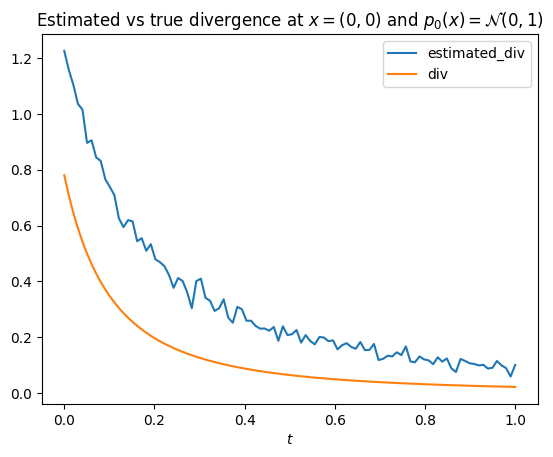

In [16]:
reward_function = GaussianRewardFunction(torch.tensor([0.0, 0.0]), target_sigma_squared)
div_estimates = -get_mc_div_term(reward_function, gaussian_score, 100, beta, x, t).detach()

de_mean, de_std = div_estimates.mean(1), div_estimates.std(1)
plt.plot(t, de_mean, label='estimated_div')
#plt.fill_between(t, de_mean - de_std, de_mean + de_std, alpha=0.2)

gaussian_score = partial(true_gaussian_path_score, target_sigma_squared, beta)
plt.plot(t, -beta / 2 * true_divergence(target_sigma_squared, beta, gaussian_score, x, t).detach(), label='div')

plt.legend()

plt.title(r'Estimated vs true divergence at $x = (0, 0)$ and $p_0(x) = \mathcal{N}(0, 1)$')
plt.xlabel(r'$t$')

Text(0.5, 0, '$t$')

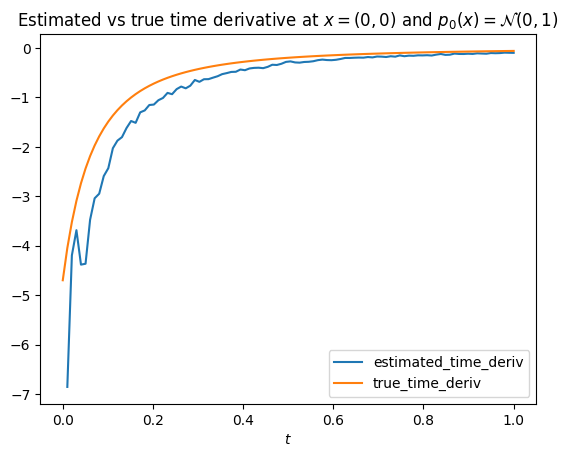

In [8]:
time_deriv_estimates = get_mc_time_deriv_term(reward_function, gaussian_score, 1000, beta, x, t).detach()
td_mean, td_std = time_deriv_estimates.mean(1), time_deriv_estimates.std(1)
plt.plot(t, td_mean, label='estimated_time_deriv')
#plt.fill_between(t, td_mean - td_std, td_mean + td_std, alpha=0.2)

partial_direct_time_deriv = partial(direct_time_derivative, target_sigma_squared, beta)
true_time_deriv = partial_direct_time_deriv(x, t).detach()
plt.plot(t, true_time_deriv, label='true_time_deriv')

plt.legend()

plt.title(r'Estimated vs true time derivative at $x = (0, 0)$ and $p_0(x) = \mathcal{N}(0, 1)$')
plt.xlabel(r'$t$')

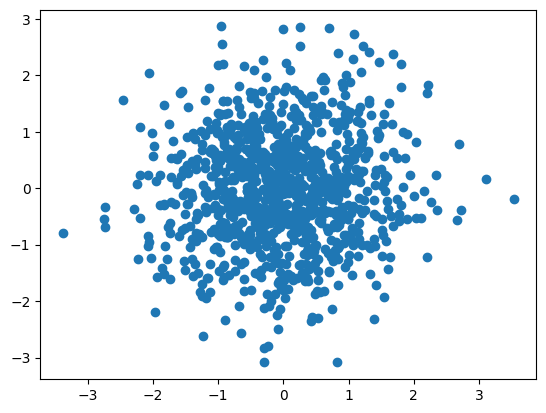

In [18]:
num_samples = 1000

dataset = torch.normal(torch.zeros((num_samples, 2)), torch.full((num_samples, 2), target_sigma_squared ** 0.5))
plt.scatter(*dataset.T)

In [11]:
import time

class GaussianPolicy(torch.nn.Module):
    def __init__(self, dim):
        super(GaussianPolicy, self).__init__()
        self.t_model = torch.nn.Sequential(
            torch.nn.Linear(128,128),torch.nn.GELU(),
            torch.nn.Linear(128,128),torch.nn.GELU(),
            torch.nn.Linear(128,64),torch.nn.GELU()
        )
        self.x_model = torch.nn.Sequential(
            torch.nn.Linear(dim,128),torch.nn.GELU(),
            torch.nn.Linear(128,128),torch.nn.GELU(),
            torch.nn.Linear(128,64),torch.nn.GELU()
        )
        self.joint_model = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.GELU(),
            torch.nn.Linear(128,128),torch.nn.GELU(),
            torch.nn.Linear(128,128),torch.nn.GELU(),
            torch.nn.Linear(128,dim)
        )
        self.harmonics = torch.nn.Parameter(torch.arange(1,64+1).float() * 2 * np.pi).requires_grad_(False)

    def forward(self, x, t):
        #import pdb; pdb.set_trace()
        cat_dim = t.ndim
        if t.ndim < x.ndim:
            t = t.unsqueeze(cat_dim)
        else:
            cat_dim -= 1
        
        t_fourier1 = (t * self.harmonics).sin()
        t_fourier2 = (t * self.harmonics).cos()
        t_emb = self.t_model(torch.cat([t_fourier1, t_fourier2], cat_dim))
        x_emb = self.x_model(x)
        
        if t_emb.ndim < x_emb.ndim:
            t_emb = t_emb.unsqueeze(0).expand(len(x_emb), -1)
            cat_dim += 1
        
        return self.joint_model(torch.cat([t_emb,x_emb], cat_dim))
    
class DumbTimeEmbeddingNet(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(dim + 1,64),torch.nn.GELU(),
            torch.nn.Linear(64,64),torch.nn.GELU(),
            torch.nn.Linear(64,dim)
        )

    def forward(self, x, t):
        #import pdb; pdb.set_trace()
        cat_dim = t.ndim
        if t.ndim < x.ndim:
            t = t.unsqueeze(cat_dim)
        else:
            cat_dim -= 1
            
        return self.model(torch.cat([x, t], cat_dim))

In [40]:
import random
torch.autograd.set_detect_anomaly(False)

est_score_model = GaussianPolicy(2).to(device=DEVICE)
optim = torch.optim.Adam([{'params': list(est_score_model.parameters()), 'lr': 1e-4}])

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

timer = time.time()
errs = []
log = []
the_log = []
bs = 256

had_zero_reward_yet = False

num_samples = 1000
dataset = torch.normal(torch.zeros((num_samples, 2)), torch.full((num_samples, 2), target_sigma_squared ** 0.5))
dataset = dataset.to(device=DEVICE)
dataset = dataset[torch.randperm(len(dataset))]
for it in range(5000):
    num_batches = int(np.ceil(len(dataset) / float(bs)))
    #if it % 1000 == 0:
    #    import pdb; pdb.set_trace()
    can_stop = it == 37
    for batch_idx in range(num_batches):
        start_idx = bs * batch_idx
        end_idx = start_idx + bs
        
        x_0 = dataset[start_idx : end_idx].clone().detach()
        t = torch.rand(len(x_0), device=DEVICE)#.unsqueeze(1).expand(x_0.shape)
        x_sampled = x_0 + torch.normal(torch.zeros_like(x_0), (beta * t.unsqueeze(1)) ** 0.5)

        #if it == 24 and batch_idx == 0:
        #    import pdb; pdb.set_trace()
        #if it == 2 and batch_idx == 219:
        loss = reward_matching_loss_dumb(reward_function, est_score_model, beta, x_sampled, t)
        #if loss.isnan().any():
        #    print(f'nan loss at epoch {it} batch idx {batch_idx}')
        #    val = get_loss_term(mixture_rewar, est_score_model, 10, beta, x_sampled, t, weight_by_norm=True, reward_thresh=0.0).mean()
        #    import pdb; pdb.set_trace()
        #loss.retain_grad()
        loss.backward()
        #except:
        #    print(it, batch_idx)
        #    import pdb; pdb.set_trace()
        torch.nn.utils.clip_grad_norm_(est_score_model.parameters(), 1.0)
        optim.step()
        optim.zero_grad()

        log.append((loss.mean().item()))
    
    if it%100==0:
        the_log_entry = np.array([ np.array(log[-10:]).mean(0) ])
        the_log.append(the_log_entry)
        print(it, the_log_entry, time.time()-timer)

0 [5.94155157] 0.022368192672729492
100 [2.47245812] 2.030458450317383
200 [2.47627881] 3.9970107078552246
300 [2.44404075] 5.973934888839722
400 [2.54408777] 7.9479124546051025
500 [2.50961163] 9.923902988433838
600 [2.51764386] 11.908761501312256
700 [2.55017213] 13.869919776916504
800 [2.4289731] 15.85633635520935
900 [2.60088263] 17.841329097747803
1000 [2.53874733] 19.80492329597473
1100 [2.46377819] 21.800062656402588
1200 [2.53992953] 23.765688180923462
1300 [2.50377514] 25.757603883743286
1400 [2.57708232] 27.7335364818573
1500 [2.49137623] 29.714008808135986
1600 [2.50183148] 31.69861125946045
1700 [2.44123068] 33.663002014160156
1800 [2.51428003] 35.64133262634277
1900 [2.66688838] 37.62298345565796
2000 [2.47251213] 39.584250926971436
2100 [2.46088881] 41.585909843444824
2200 [2.44009004] 43.55992007255554
2300 [2.42111378] 45.52986931800842
2400 [2.47472801] 47.45461654663086
2500 [2.41208758] 49.36320400238037
2600 [2.48505025] 51.31760048866272
2700 [2.43552816] 53.256196

In [42]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

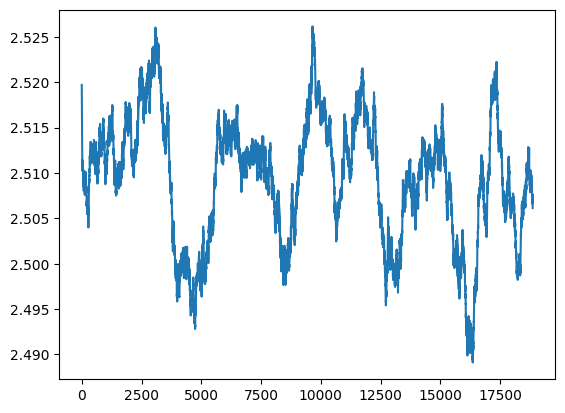

In [45]:
if isinstance(log, list):
    log = np.array(log)

plt.plot(moving_average(log[~is_outlier(log)], 1000))

In [97]:
# Define values to compute for

x = dataset[5].clone()#torch.tensor([[0.25, 0.5]])
t = torch.linspace(0.0, 1.0, 100)
x = x.expand(100, 2)

Text(0.5, 0, '$t$')

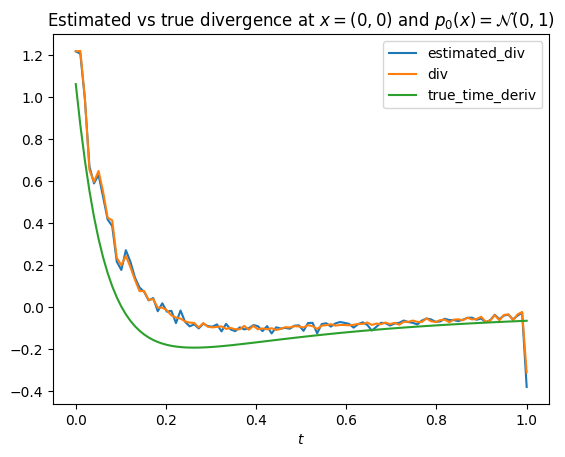

In [98]:
reward_function = GaussianRewardFunction(torch.tensor([0.0, 0.0]), target_sigma_squared)
div_estimates = get_mc_div_term(reward_function, est_score_model, 1000, beta, x, t).detach()

de_mean, de_std = div_estimates.mean(1), div_estimates.std(1)
plt.plot(t, -de_mean, label='estimated_div')
#plt.fill_between(t, de_mean - de_std, de_mean + de_std, alpha=0.2)

gaussian_score = partial(true_gaussian_path_score, target_sigma_squared, beta)
plt.plot(t, -beta / 2 * true_divergence(target_sigma_squared, beta, est_score_model, x, t).detach() * reward_function.normalization_constant, label='div')

#time_deriv_estimates = get_mc_time_deriv_term(reward_function, gaussian_score, 5000, beta, x, t).detach()
#td_mean, td_std = time_deriv_estimates.mean(1), time_deriv_estimates.std(1)
#plt.plot(t, td_mean, label='estimated_time_deriv')
#plt.fill_between(t, td_mean - td_std, td_mean + td_std, alpha=0.2)

partial_direct_time_deriv = partial(direct_time_derivative, target_sigma_squared, beta)
true_time_deriv = partial_direct_time_deriv(x, t).detach() * reward_function.normalization_constant
plt.plot(t, true_time_deriv, label='true_time_deriv')

plt.legend()

plt.title(r'Estimated vs true divergence at $x = (0, 0)$ and $p_0(x) = \mathcal{N}(0, 1)$')
plt.xlabel(r'$t$')

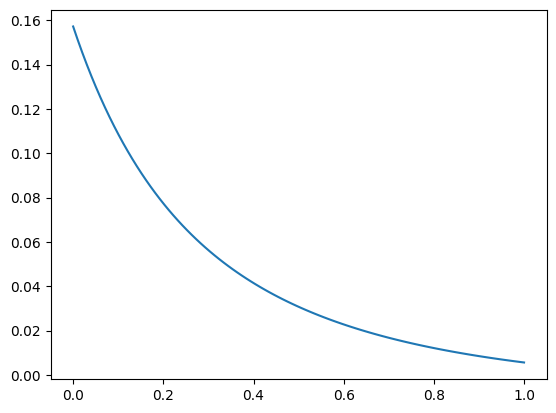

In [238]:
plt.plot(t, (true_time_deriv.squeeze().abs() - (beta / 2 * true_divergence(target_sigma_squared, beta, score_model, x, t)).detach().abs()))

Text(0.5, 0, '$t$')

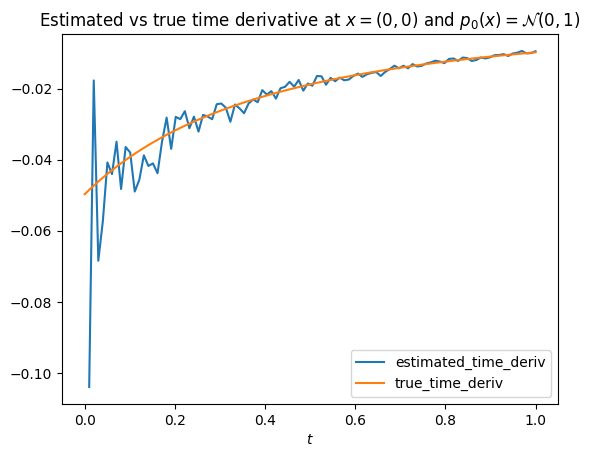

In [139]:
time_deriv_estimates = get_mc_time_deriv_term(reward_function, gaussian_score, 1000, beta, x, t).detach()
td_mean, td_std = time_deriv_estimates.mean(1), time_deriv_estimates.std(1)
plt.plot(t, td_mean, label='estimated_time_deriv')
#plt.fill_between(t, td_mean - td_std, td_mean + td_std, alpha=0.2)

partial_direct_time_deriv = partial(direct_time_derivative, target_sigma_squared, beta)
true_time_deriv = partial_direct_time_deriv(x, t).detach()
plt.plot(t, true_time_deriv, label='true_time_deriv')

plt.legend()

plt.title(r'Estimated vs true time derivative at $x = (0, 0)$ and $p_0(x) = \mathcal{N}(0, 1)$')
plt.xlabel(r'$t$')

In [47]:
!pip install torchsde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 11.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [48]:
import torch
import torch as T
import torchsde

class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score_net):
        super().__init__()
        self.score_model = score_net
    
    def f(self, t, x):
        #import pdb; pdb.set_trace()
        score = self.score_model(x, 1-t)
        return self.g(t, x).pow(2) * score 
    
    def g(self, t, x):
        return torch.full_like(x, beta ** 0.5)

In [49]:
ve_reverse_sde = VEReverseSDE(est_score_model)

num_samples = 400
x1 = torch.normal(torch.zeros((num_samples, 2)), torch.full((num_samples, 2), (target_sigma_squared + beta) ** 0.5))
t = torch.linspace(0.0, 1.0, 1000)

with torch.no_grad():
    samples = torchsde.sdeint(ve_reverse_sde, x1, t)

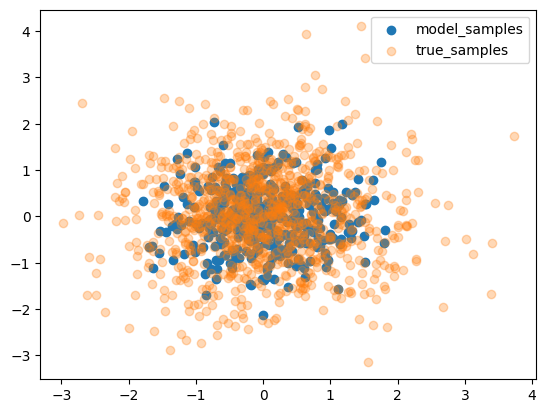

In [52]:
plt.scatter(*samples[-1].T.flip(0), label='model_samples')
plt.scatter(*dataset.T, label='true_samples', alpha=0.3)
#plt.scatter(*samples[0].T, label='x1', alpha=0.3)
plt.legend()
#plt.scatter(*samples[0].T)

In [132]:
samples[-1].mean(dim=0)
samples[-1].std(dim=0)

tensor([1.3452, 1.4318])

## Trying to sample from a Gaussian mixture

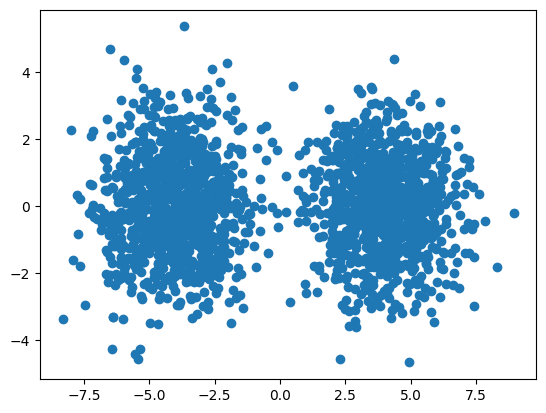

In [55]:
num_samples = 1000
shift = 4

center_one = torch.zeros((num_samples, 2))
center_one[:, 0] = -shift

center_two = torch.zeros((num_samples, 2))
center_two[:, 0] = shift

samples_one = torch.normal(center_one, (torch.ones((len(center_one), 1)) + (beta * 0.2)).pow(0.5))
samples_two = torch.normal(center_two, (torch.ones((len(center_one), 1)) + (beta * 0.2)).pow(0.5))

dataset = torch.cat([samples_one, samples_two], dim=0)

plt.scatter(*dataset.T)

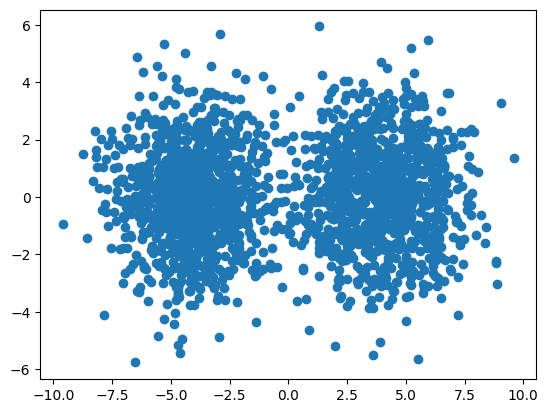

In [116]:
plt.scatter(*dataset.T)

In [56]:
class GaussianMixtureRewardFunction:
    def __init__(self, gaussian_rewards, beta_val):
        self.gaussian_rewards = gaussian_rewards
        
        log_normalization_constants = torch.tensor([x.normalization_constant for x in gaussian_rewards]).log()
        
        log_norm_constant_mtx = log_normalization_constants.unsqueeze(0).expand(
            len(log_normalization_constants),
            len(log_normalization_constants)
        )
        
        mask = ~torch.eye(len(log_normalization_constants)).bool()
        
        self.log_reward_weight = (log_norm_constant_mtx * mask).sum(dim=1)
        self._normalization_constant = log_normalization_constants.sum().exp() * len(self.gaussian_rewards)
        self.beta_val = beta_val
        
    def get_unnormalized_log_reward(self, x):
        log_rewards = []
        for i, reward in enumerate(self.gaussian_rewards):
            log_rewards.append((self.log_reward_weight[i] + reward.get_unnormalized_log_reward(x)).unsqueeze(0))
            
        return torch.logsumexp(torch.cat(log_rewards, dim=0), dim=0)
    
    def get_unnormalized_reward(self, x):
        return self.get_unnormalized_log_reward(x).exp()
    
    def true_probability_path(self, x, t):
#        return self.get_unnormalized_log_reward(x
        probs = torch.zeros_like(t)#(len(x) if x.ndim > 1 else 1)
        for reward_fxn in self.gaussian_rewards:
            distrib = torch.distributions.multivariate_normal.MultivariateNormal(
                loc=reward_fxn.mean, 
                covariance_matrix=(reward_fxn.variance + (self.beta_val * t)) * torch.eye(2),
                validate_args=False
            )

            probs = probs + distrib.log_prob(x).exp()
            
        return probs / len(self.gaussian_rewards)
    
    def true_score(self, x, t):
        if t.ndim == 0:
            t = torch.full_like(x, t)[:, 0]
            
        def _log_prob_path(x, t):
            #import pdb; pdb.set_trace()    
            return self.true_probability_path(x, t).log()
        
        return torch.vmap(torch.func.grad(_log_prob_path))(x, t)
    
    @property
    def normalization_constant(self):
        return self._normalization_constant
    
def direct_time_derivative_mixture(reward, x, t):
    grad_fxn = torch.func.jacrev(reward.true_probability_path, argnums=1)
    return torch.vmap(grad_fxn)(x, t)

def mixture_true_divergence(reward, vector_field, x, t):
    #import pdb; pdb.set_trace()
    def likelihood_vf_product(x_val, t_val):
        pdf_vals = reward.true_probability_path(x_val, t_val)
        vf_vals = vector_field(x_val.to(device=DEVICE), t_val.to(device=DEVICE))
        
        return pdf_vals * vf_vals.to(device='cpu')
    
    jac_fxn = torch.func.jacfwd(likelihood_vf_product)
    jacs = torch.vmap(jac_fxn)(x, t)

    return torch.vmap(torch.trace)(jacs)

def exact_loss(reward, vector_field, x, t):
    time_deriv = direct_time_derivative_mixture(reward, x, t).squeeze()
    div = mixture_true_divergence(reward, vector_field, x, t) * beta / 2
    
    return (time_deriv + div).pow(2).mean()

In [57]:
reward_fxn_one = GaussianRewardFunction(torch.tensor([0.0, -shift]), 1.0)
reward_fxn_two = GaussianRewardFunction(torch.tensor([0.0, shift]), 1.0)
beta = 10

mixture_reward = GaussianMixtureRewardFunction([reward_fxn_one, reward_fxn_two], beta)

In [18]:
def get_loss_term_return_ests(reward_fxn, vector_field, num_mc_samples, constant_noise_scale, x, t):
    orig_len = len(x)
    if num_mc_samples > 1:
        x = x.repeat_interleave(num_mc_samples, dim=0)
        
        orig_t = t.clone()
        t = t.repeat_interleave(num_mc_samples, dim=0)

    #import pdb; pdb.set_trace()
    t = t.unsqueeze(1)
    noise = constant_noise_scale * t
    samples = torch.normal(x, noise ** 0.5)
    
    time_deriv_term = _get_time_deriv_scaling(reward_fxn, vector_field, constant_noise_scale, samples, x, t)
    div_term = _get_divergence_term(reward_fxn, vector_field, constant_noise_scale, samples, x, t)
    rewards = reward_fxn.get_unnormalized_reward(samples)
    
    weighted_terms = rewards * (time_deriv_term + div_term)
    if num_mc_samples > 1:
        weighted_terms = weighted_terms.reshape(
            int(orig_len),
            num_mc_samples
        ).mean(dim=1)
        
        #time_deriv_term = (rewards * time_deriv_term).reshape(int(orig_len), num_mc_samples)
        
    return weighted_terms.pow(2)

0 [16.49754548] 0.04509878158569336


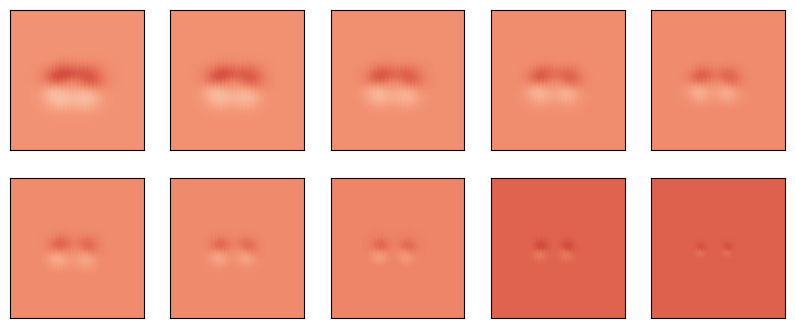

500 [4.87658653] 23.199506282806396


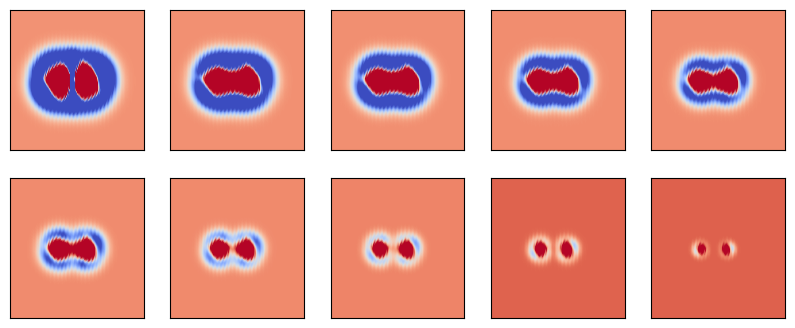

1000 [4.88259239] 46.47821402549744


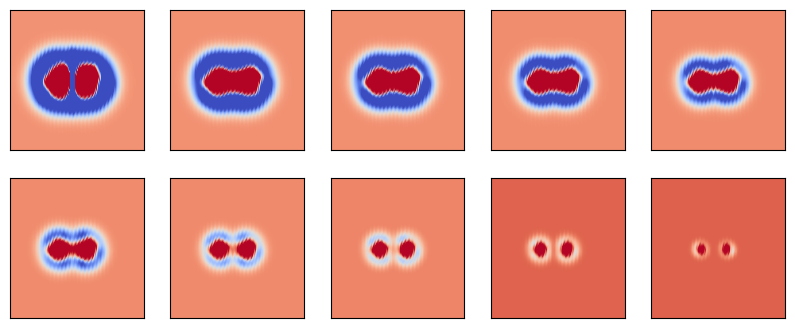

KeyboardInterrupt: 

In [72]:
import random

score_model = GaussianPolicy(2)
optim = torch.optim.Adam([{'params': list(score_model.parameters()), 'lr': 5e-4}])
    
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

timer = time.time()
errs = []
log = []
the_log = []
bs = 256

had_zero_reward_yet = False

dataset = dataset.to(device=DEVICE)
for it in range(4000):
    dataset = dataset[torch.randperm(len(dataset))]
    num_batches = int(np.ceil(len(dataset) / float(bs)))
    #if it % 1000 == 0:
    #    import pdb; pdb.set_trace()
    can_stop = it == 37
    for batch_idx in range(num_batches):
        start_idx = bs * batch_idx
        end_idx = start_idx + bs
        
        x_0 = dataset[start_idx : end_idx].clone().detach()
        #x_0 = torch.tensor([[0.0, -shift], [0.0, shift], [1.0, shift]])
        t = torch.rand(len(x_0))#.unsqueeze(1).expand(x_0.shape)
        x_sampled = x_0 + torch.normal(torch.zeros_like(x_0), (beta * t.unsqueeze(1)) ** 0.5)
        #x_sampled = x_0

        #loss = exact_loss(mixture_reward, score_model, x_sampled, t)
        #loss = get_log_odd_fxn_loss(mixture_reward, score_model, 10, beta, x_sampled, t, weight_by_norm=False).mean()
        loss = reward_matching_loss_dumb(mixture_reward, score_model, beta, x_sampled, t)

        #loss = (get_loss_term_return_ests(mixture_reward, score_model, 1, beta, x_sampled, t).mean())# * (beta * t).pow(2)).mean()

        loss.backward()
        #torch.nn.utils.clip_grad_norm_(score_model.parameters(), 1.0)
        optim.step()
        optim.zero_grad()

        log.append((loss.mean().item()))

    if it%500==0:
        the_log_entry = np.array([ np.array(log[-10:]).mean(0) ])
        the_log.append(the_log_entry)
        print(it, the_log_entry, time.time()-timer)
        plot_true_divergence(score_model)

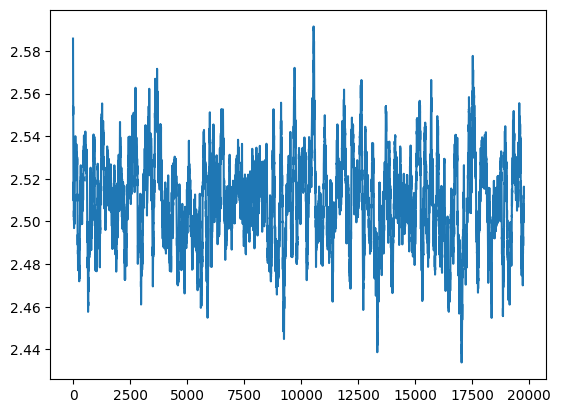

In [44]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

if isinstance(log, list):
    log = np.array(log)
    
plt.plot(moving_average(log[~is_outlier(log)], 100))

In [23]:
!pip install torchsde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 11.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [75]:
import torchsde

ve_reverse_sde = VEReverseSDE(score_model)

num_samples = 1000
shift = 4

center_one = torch.zeros((num_samples, 2))
center_one[:, 0] = -shift

center_two = torch.zeros((num_samples, 2))
center_two[:, 0] = shift

samples_one = torch.normal(center_one, (torch.ones((len(center_one), 1)) + (beta)).pow(0.5))
samples_two = torch.normal(center_two, (torch.ones((len(center_one), 1)) + (beta)).pow(0.5))

pre_dataset = torch.cat([samples_one, samples_two], dim=0)
num_samples = 2000
x1 = pre_dataset#torch.normal(pre_dataset, beta ** 0.5)
#x1 = torch.normal(torch.zeros((num_samples, 2)), torch.full((num_samples, 2), beta ** 0.5))
t = torch.linspace(0.0, 1.0, 1000)

with torch.no_grad():
    samples = torchsde.sdeint(ve_reverse_sde, x1, t)

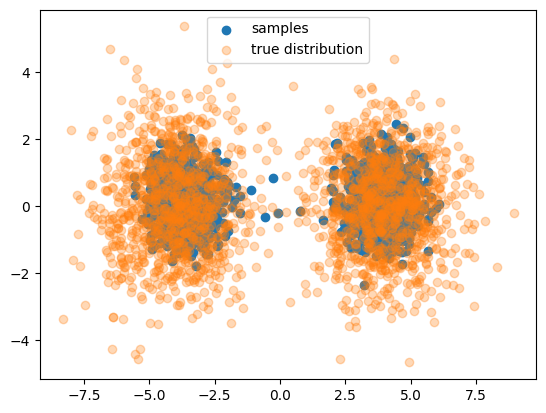

In [77]:
plt.scatter(*samples[-1].T.flip(0), label='samples')
#plt.scatter(*samples[0].T, label='begin')
plt.scatter(*dataset.T, label='true distribution', alpha=0.3)
plt.legend()

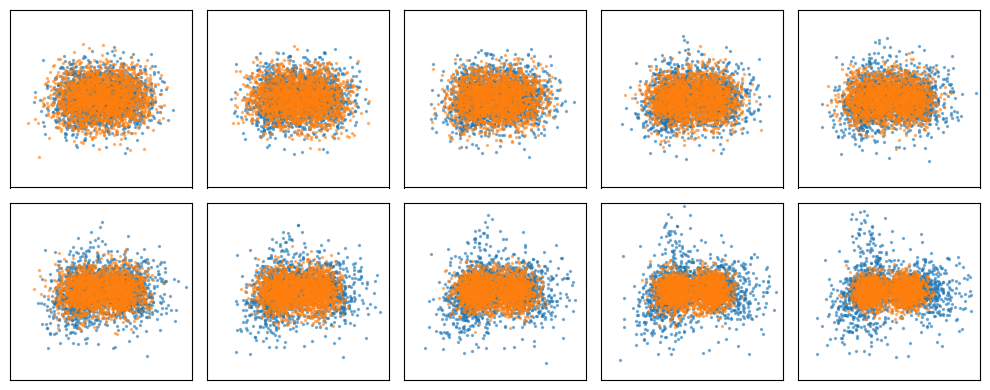

In [50]:
plt.figure(figsize=(10,4))
for j in range(0,1001,101):
    plt.subplot(2,5,j//101+1)
    plt.xlim(-20,20);plt.ylim(-20,20)
    plt.xticks([]);plt.yticks([])
    plt.scatter(*samples[j].T, label='samples',s=2,alpha=0.5)
    plt.scatter(*dataset.T+T.randn_like(dataset.T)*(beta*(1000-j)/1000.)**0.5, label='true distribution',s=2,alpha=0.5)
plt.tight_layout()
plt.show()

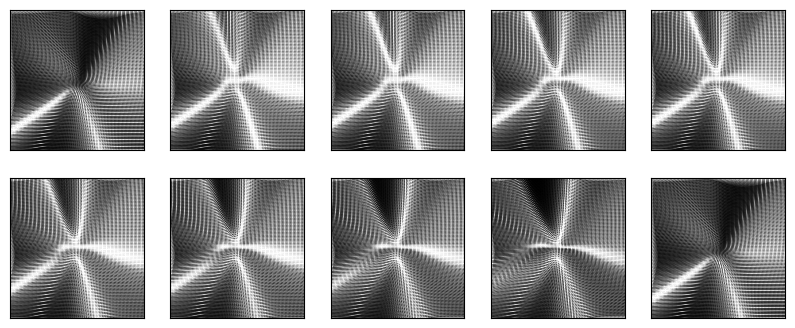

In [64]:
plt.figure(figsize=(10,4))
n = 100
x = torch.linspace(-20, 20, n)
y = torch.linspace(-20, 20, n)
X, Y = torch.meshgrid(x, y)
grid = torch.stack([X.flatten(), Y.flatten()], dim=1)
for i in range(10):
    t = i / 9.
    with torch.no_grad():
        score = score_model(grid, torch.full((grid.shape[0],), 1-t))
    score = score.reshape(n, n, 2)
    plt.subplot(2,5,i+1)
    plt.xlim(-20,20);plt.ylim(-20,20)
    plt.xticks([]);plt.yticks([])
    plt.quiver(X, Y, score[..., 0], score[..., 1], scale=20, linewidth=2)
plt.show()

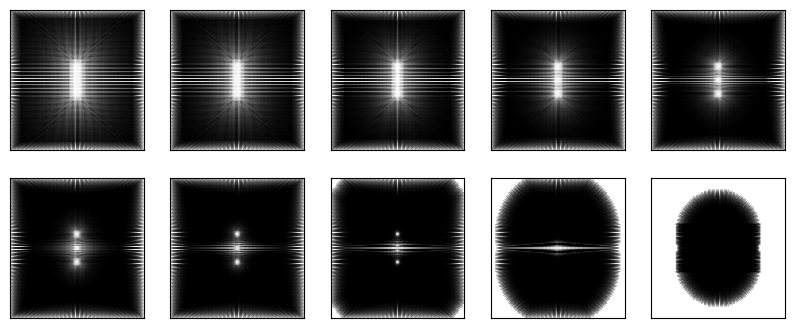

In [65]:
plt.figure(figsize=(10,4))
n = 100
x = torch.linspace(-20, 20, n)
y = torch.linspace(-20, 20, n)
X, Y = torch.meshgrid(x, y)
grid = torch.stack([X.flatten(), Y.flatten()], dim=1)
for i in range(10):
    t = i / 9.
    score = mixture_reward.true_score(grid, torch.full((grid.shape[0],), 1-t))
    score = score.reshape(n, n, 2)
    plt.subplot(2,5,i+1)
    plt.xlim(-20,20);plt.ylim(-20,20)
    plt.xticks([]);plt.yticks([])
    plt.quiver(X, Y, score[..., 0], score[..., 1], scale=20, linewidth=2)
plt.show()

In [60]:
def plot_true_divergence(curr_score_model):
    plt.figure(figsize=(10,4))
    n = 100
    x = torch.linspace(-20, 20, n)
    y = torch.linspace(-20, 20, n)
    X, Y = torch.meshgrid(x, y)
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1)
    min_vals, max_vals = [], []
    for i in range(10):
        t = i / 9.
        divs = mixture_true_divergence(mixture_reward, curr_score_model, grid, torch.full((grid.shape[0],), 1-t)).detach()
        divs = -beta / 2 * divs * mixture_reward.normalization_constant
        divs = divs.reshape(n, n).T
        plt.subplot(2,5,i+1)
        plt.xlim(-20,20);plt.ylim(-20,20)
        plt.xticks([]);plt.yticks([])
        plt.scatter(X, Y, c=divs, cmap='coolwarm')#, vmin=other_min[i], vmax=other_max[i], cmap='coolwarm')

        min_vals.append(divs.min().item())
        max_vals.append(divs.max().item())

        #plt.quiver(X, Y, score[..., 0], score[..., 1], scale=20, linewidth=2)
    plt.show()

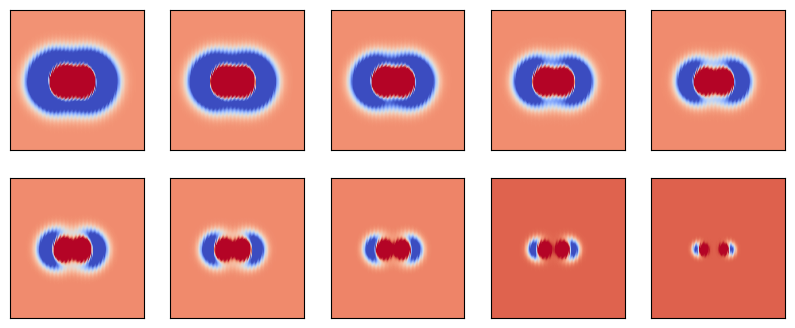

In [64]:
plot_true_divergence(est_score_model)

/home/ray/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


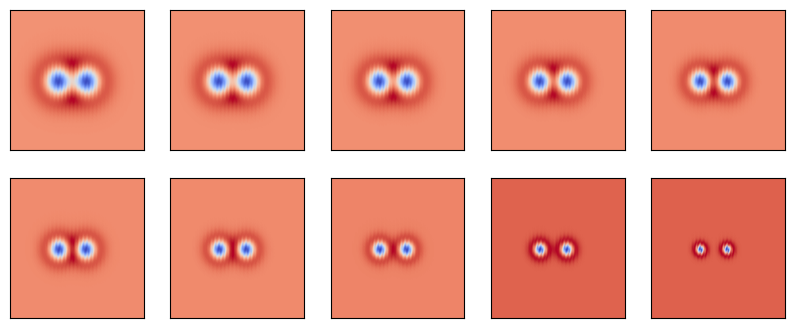

In [59]:
plt.figure(figsize=(10,4))
n = 100
x = torch.linspace(-20, 20, n)
y = torch.linspace(-20, 20, n)
X, Y = torch.meshgrid(x, y)
grid = torch.stack([X.flatten(), Y.flatten()], dim=1)
other_min, other_max = [], []
for i in range(10):
    t = i / 9.
    partial_direct_time_deriv = partial(direct_time_derivative_mixture, mixture_reward)
    true_time_deriv = partial_direct_time_deriv(grid, torch.full((grid.shape[0],), 1-t)).detach() * mixture_reward.normalization_constant
    true_time_deriv = true_time_deriv.reshape(n, n).T
    plt.subplot(2,5,i+1)
    plt.xlim(-20,20);plt.ylim(-20,20)
    plt.xticks([]);plt.yticks([])
    
    other_min.append(true_time_deriv.min().item())
    other_max.append(true_time_deriv.max().item())
    
    plt.scatter(X, Y, c=true_time_deriv, vmin=other_min[i], vmax=other_max[i], cmap='coolwarm')
    
    #plt.quiver(X, Y, score[..., 0], score[..., 1], scale=20, linewidth=2)
plt.show()

In [91]:
true_min_vals, true_max_vals = [], []
for i in range(10):
    true_min_vals.append(min(min_vals[i], other_min[i]))
    true_max_vals.append(min(max_vals[i], other_max[i]))

In [66]:
# Define values to compute for

x = dataset[0].clone()#torch.tensor([[0, shift]], dtype=torch.float)
t = torch.linspace(0.01, 1.0, 100)
x = x.expand(100, 2)

Text(0.5, 0, '$t$')

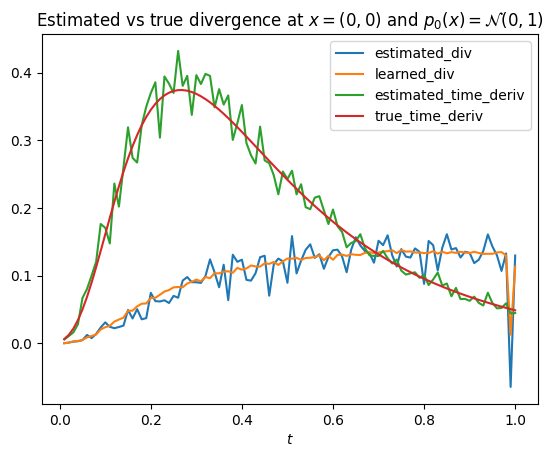

In [67]:
div_estimates = get_mc_div_term(mixture_reward, score_model, 1000, beta, x, t).detach()

de_mean, de_std = div_estimates.mean(1), div_estimates.std(1)
plt.plot(t, -de_mean, label='estimated_div')
#plt.fill_between(t, de_mean - de_std, de_mean + de_std, alpha=0.2)

divs = mixture_true_divergence(mixture_reward, score_model, x, t).detach()
plt.plot(t, -beta / 2 * divs * mixture_reward.normalization_constant, label='learned_div')

time_deriv_estimates = get_mc_time_deriv_term(mixture_reward, gaussian_score, 10000, beta, x, t).detach()
td_mean, td_std = time_deriv_estimates.mean(1), time_deriv_estimates.std(1)
plt.plot(t, td_mean, label='estimated_time_deriv')
#plt.fill_between(t, td_mean - td_std, td_mean + td_std, alpha=0.2)

partial_direct_time_deriv = partial(direct_time_derivative_mixture, mixture_reward)
true_time_deriv = partial_direct_time_deriv(x, t).detach() * mixture_reward.normalization_constant
plt.plot(t, true_time_deriv, label='true_time_deriv')

plt.legend()

plt.title(r'Estimated vs true divergence at $x = (0, 0)$ and $p_0(x) = \mathcal{N}(0, 1)$')
plt.xlabel(r'$t$')

In [28]:
def plot_divergence_prob_path(x_val, num_samp_per_t, num_t_vals):
    plot_t = torch.linspace(0.0, 1.0, num_t_vals)
    t = plot_t.repeat_interleave(num_samp_per_t)
    
    x_val = x_val.unsqueeze(0).expand(len(t), 2)
    
    samples = torch.normal(x_val, (beta * t.unsqueeze(1)) ** 0.5)
    div_estimates = get_mc_div_term(mixture_reward, est_score_model, 10, beta, samples, t).detach()

    de_mean = div_estimates.mean(1)
    de_mean = de_mean.reshape(num_t_vals, num_samp_per_t).mean(1)
    
    plt.plot(plot_t, -de_mean, label='estimated_div')
    
    #time_deriv_estimates = get_mc_time_deriv_term(mixture_reward, gaussian_score, 1000, beta, samples, t).detach()
    #td_mean, td_std = time_deriv_estimates.mean(1), time_deriv_estimates.std(1)
    #plt.plot(t, td_mean, label='estimated_time_deriv')

    partial_direct_time_deriv = partial(direct_time_derivative_mixture, mixture_reward)
    true_time_deriv = partial_direct_time_deriv(samples, t).detach() * mixture_reward.normalization_constant
    true_time_deriv = true_time_deriv.reshape(num_t_vals, num_samp_per_t).mean(1)
    
    plt.plot(plot_t, true_time_deriv, label='true_time_deriv')
    
    
    plt.legend()
    plt.xlabel(r'$t$')
    plt.ylabel(r'$E_{x \sim \mathcal{N}(x_0, h(t))}[term(x)]$')

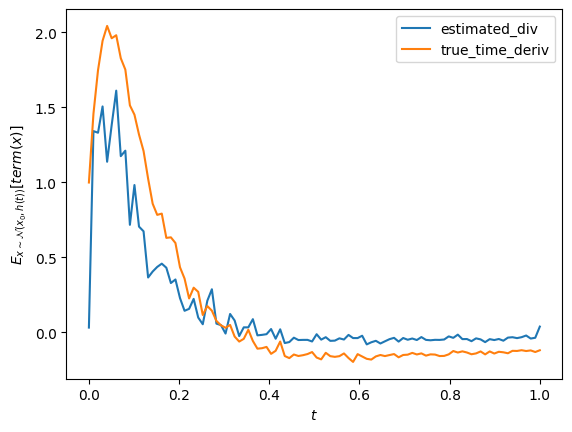

In [30]:
plot_divergence_prob_path(dataset[0].clone(), 1000, 100)

In [105]:
dataset.abs().mean(1).argsort()

tensor([ 428, 1510,   66,  ...,  354, 1305,  663])

In [ ]:
divs.shape

In [7]:
import numpy as np
import matplotlib.pyplot as plt

sigma_min = 1e-5
sigma_max = 100.0

t = np.linspace(0.0, 1.0, 100)

ht = (sigma_min * (((sigma_max / sigma_min) ** t) - 1)) / np.log(sigma_max / sigma_min)

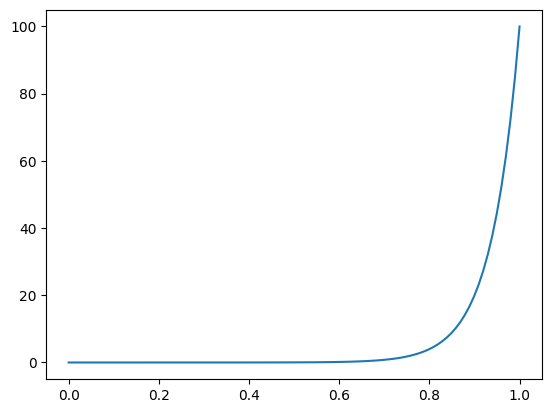

In [8]:
plt.plot(t, ht)

In [9]:
ht

array([0.00000000e+00, 1.76811952e-06, 3.84886371e-06, 6.29750835e-06,
       9.17910262e-06, 1.25701972e-05, 1.65608778e-05, 2.12571585e-05,
       2.67837977e-05, 3.32876128e-05, 4.09413801e-05, 4.99484250e-05,
       6.05480231e-05, 7.30217568e-05, 8.77009957e-05, 1.04975700e-04,
       1.25304777e-04, 1.49228279e-04, 1.77381742e-04, 2.10513074e-04,
       2.49502421e-04, 2.95385551e-04, 3.49381366e-04, 4.12924287e-04,
       4.87702356e-04, 5.75702082e-04, 6.79261210e-04, 8.01130831e-04,
       9.44548457e-04, 1.11332403e-03, 1.31194115e-03, 1.54567614e-03,
       1.82073828e-03, 2.14443469e-03, 2.52536449e-03, 2.97364724e-03,
       3.50119173e-03, 4.12201240e-03, 4.85260158e-03, 5.71236766e-03,
       6.72415066e-03, 7.91482898e-03, 9.31603347e-03, 1.09649877e-02,
       1.29054967e-02, 1.51891108e-02, 1.78764953e-02, 2.10390414e-02,
       2.47607636e-02, 2.91405306e-02, 3.42946929e-02, 4.03601726e-02,
       4.74981016e-02, 5.58981018e-02, 6.57833225e-02, 7.74163683e-02,
      

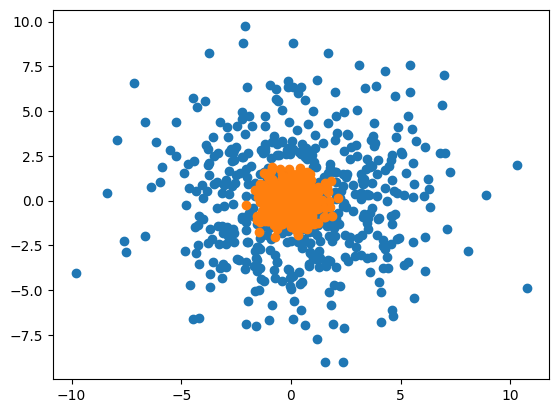

In [63]:
plt.scatter(*torch.normal(torch.zeros((500,2)), 10 ** 0.5).T)
plt.scatter(*torch.normal(torch.zeros((500,2)), 0.5 ** 0.5).T)